In [3]:
import logging

import networkx as nx
import igraph as ig
import numpy as np

import pymetis
from sklearn import cluster

from evaluation import synthetic
from sharetrace import propagation
from synthetic import (
    DatasetFactory,
    IGraph,
    ScoreFactory,
    UniformBernoulliValueFactory,
    Dataset, 
    HistoryFactory,
    TimeFactory,
    LocationFactory,
    ContactFactory,
    ConnectedCavemanGraphFactory)

In [4]:
def adjlist(g: ig.Graph):
    return g.get_adjlist()


def adjmat(g: ig.Graph):
    return np.array(list(g.get_adjacency()))


def metis_partition(g: ig.Graph, parts: int):
    _, labels = pymetis.part_graph(parts, adjmat(g))
    return np.array(labels)


def spectral_partition(g: ig.Graph, parts: int):
    spectral = cluster.SpectralClustering(
        parts, affinity='precomputed', n_init=100, assign_labels='discretize')
    return spectral.fit_predict(adjmat(g))

def graph_factory(n):
    return IGraph(ig.Graph.Barabasi(n, 1))

def create_data(
        users: int = 10_000,
        days: int = 15,
        per_day: int = 16,
        low: float = -1,
        high: float = 1,
        step_low: float = -0.01,
        step_high: float = 0.01,
        p: float = 0.2,
        save: bool = False) -> Dataset:
    dataset_factory = DatasetFactory(
        score_factory=ScoreFactory(
            value_factory=UniformBernoulliValueFactory(per_user=days, p=p),
            time_factory=TimeFactory(days=days, per_day=1)),
        history_factory=HistoryFactory(
            loc_factory=LocationFactory(
                days=days,
                per_day=per_day,
                low=low,
                high=high,
                step_low=step_low,
                step_high=step_high),
            time_factory=TimeFactory(days=days, per_day=per_day)),
        contact_factory=ContactFactory(
            graph_factory=graph_factory,
            time_factory=TimeFactory(days=days, per_day=1, random_first=True)))
    return dataset_factory(users)

def risk_propagation(n):
    logger = logging.getLogger()
    dataset = create_data(n)
    for w in range(1, 5):
        rp = propagation.RiskPropagation(
            logger=logger, workers=w, timeout=3, tol=0.3)
        rp.run(dataset.scores, dataset.contacts)

In [ ]:
risk_propagation(100_000)

In [5]:
colors = np.array([
    'blue', 'pink', 'green', 'brown', 'grey', 'orange', 'purple', 'red'])

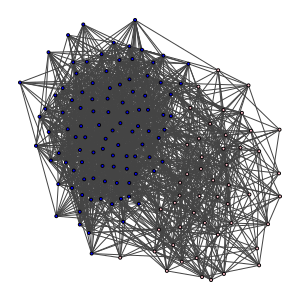

In [20]:
g = ig.Graph.from_networkx(
    nx.generators.random_partition_graph([100, 50], 0.2, 0.05))
labels = spectral_partition(g, 2)
ig.plot(
    g,
    layout=g.layout_auto(),
    vertex_color=list(colors[labels]),
    vertex_size=3,
    bbox=(300, 300),
    margin=20)

Signature:
nx.generators.random_partition_graph(
    sizes,
    p_in,
    p_out,
    seed=None,
    directed=False,
)
Docstring:
Returns the random partition graph with a partition of sizes.

A partition graph is a graph of communities with sizes defined by
s in sizes. Nodes in the same group are connected with probability
p_in and nodes of different groups are connected with probability
p_out.

Parameters
----------
sizes : list of ints
  Sizes of groups
p_in : float
  probability of edges with in groups
p_out : float
  probability of edges between groups
directed : boolean optional, default=False
  Whether to create a directed graph
seed : integer, random_state, or None (default)
    Indicator of random number generation state.
    See :ref:`Randomness<randomness>`.

Returns
-------
G : NetworkX Graph or DiGraph
  random partition graph of size sum(gs)

Raises
------
NetworkXError
  If p_in or p_out is not in [0,1]

Examples
--------
>>> G = nx.random_partition_graph([10, 10, 10], 0.